In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mushehta","key":"7d415f1b3d3c59c80eee85c5c0c547da"}'}

# **connect to kaggle and download the data**


In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dschettler8845/brats-2021-task1

100% 12.3G/12.3G [04:39<00:00, 55.9MB/s]
100% 12.3G/12.3G [04:39<00:00, 47.2MB/s]


# unzip files and make train and validation data 

In [ ]:
! unzip /content/brats-2021-task1.zip -d /content/data

import os
os.remove("/content/brats-2021-task1.zip")



In [ ]:
! mkdir /content/data/train_data

!tar -xvf /content/data/BraTS2021_Training_Data.tar -C /content/data/train_data


!mkdir /content/data/val_data

import os
os.remove("/content/data/train_data/.DS_Store")



import os
list_dir = os.listdir("/content/data/train_data")

import shutil

for i in range(100):
  src_path = "/content/data/train_data/" + list_dir[i]
  dst_path = r"/content/data/val_data"
  shutil.move(src_path, dst_path)

# install seg 3D

In [ ]:
!pip install segmentation_models_3D
!pip install keras_applications
!pip install nibabel

# load image

In [27]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def load_image(path):

    list_dir = os.listdir(path)
    regex = re.compile("(flair.nii.gz)$")
    idxs = [i for i, item in enumerate(list_dir) if re.search(regex, item)]
    img_f = nib.load(path +"/" +list_dir[idxs[0]])
    arr_f = (img_f.get_fdata())[56:184 , 56:184,13:141]
    
    regex = re.compile("(t1ce.nii.gz)$")
    idxs = [i for i, item in enumerate(list_dir) if re.search(regex, item)]
    img_t1ce = nib.load(path +"/" +list_dir[idxs[0]])
    arr_t1ce = (img_t1ce.get_fdata())[56:184 , 56:184,13:141]
    
    regex = re.compile("(t2.nii.gz)$")
    idxs = [i for i, item in enumerate(list_dir) if re.search(regex, item)]
    img_t2 = nib.load(path +"/" +list_dir[idxs[0]])
    arr_t2 = (img_t2.get_fdata())[56:184 , 56:184,13:141]
    
    regex = re.compile("(seg.nii.gz)$")
    idxs = [i for i, item in enumerate(list_dir) if re.search(regex, item)]
    img_seg = nib.load(path +"/" +list_dir[idxs[0]])
    arr_seg = (img_seg.get_fdata())[56:184 , 56:184,13:141]
    
    return arr_f , arr_t1ce , arr_t2 , arr_seg

# get image

In [28]:
def get_image(path):


    f_arr, t1ce_arr, t2_arr, seg_arr = load_image(path)
    f_arr=scaler.fit_transform(f_arr.reshape(-1, f_arr.shape[-1])).reshape(f_arr.shape)
    t1ce_arr=scaler.fit_transform(t1ce_arr.reshape(-1, t1ce_arr.shape[-1])).reshape(t1ce_arr.shape)
    t2_arr=scaler.fit_transform(t2_arr.reshape(-1, t2_arr.shape[-1])).reshape(t2_arr.shape)
    X = np.stack([f_arr , t1ce_arr ,t2_arr],  axis=3)
    
    
    y = seg_arr
    y = np.where(y == 4, 3, y)
    y = to_categorical(y, num_classes=4)
    
    return X,y

# load_img

In [17]:
def load_img(img_dir, img_list):
    images=[]
    msk = []
    for i, image_name in enumerate(img_list):  
        
      image, y = get_image(img_dir+image_name)
      images.append(image)
      msk.append(y)
    images = np.array(images)
    msk = np.array(msk)
    
    return(images , msk)

# imageLoader

In [18]:
def imageLoader(img_dir, img_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X ,  Y = load_img(img_dir, img_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

# call some lib

In [19]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam 
from keras.metrics import MeanIoU
import os

kernel_initializer =  'he_uniform'

# test model

In [29]:
train_dir = r"/content/data/train_data/"
val_dir = r"/content/data/val_data/"

from keras.models import load_model
#load the model that have been train
model = load_model('/content/brats_3d.hdf5', 
                      compile=False)


from keras.metrics import MeanIoU
batch_size=8 #Check IoU for a batch of train images
test_img_datagen = imageLoader (train_dir, os.listdir(train_dir), batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU for train data =", IOU_keras.result().numpy())


Mean IoU for train data = 0.5749489


In [30]:
batch_size=8 #Check IoU for a batch of val images
test_img_datagen = imageLoader (val_dir, os.listdir(val_dir), batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU for val data =", IOU_keras.result().numpy())


Mean IoU for val data = 0.4805888


In [33]:
!mkdir /content/data/test
!tar -xvf /content/data/BraTS2021_00495.tar -C /content/data/test

./
./BraTS2021_00495_flair.nii.gz
./BraTS2021_00495_seg.nii.gz
./BraTS2021_00495_t1.nii.gz
./BraTS2021_00495_t1ce.nii.gz
./BraTS2021_00495_t2.nii.gz


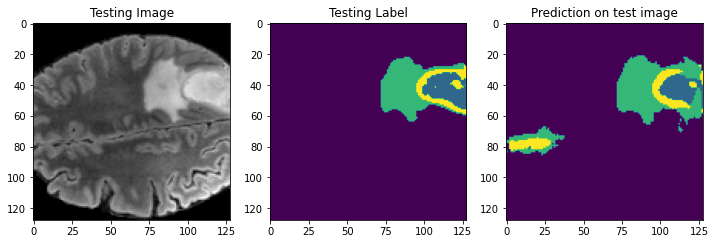

In [35]:


test_img, test_mask = get_image("/content/data/test")

test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 90
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
